**What does this pipeline do?**
   This pipeline is built to process 3' end sequencing data generated using the [3'READS+ method](https://www.ncbi.nlm.nih.gov/pubmed/27512124 "Pubmed"), which produces sequencing reads with ~13 Ts in the beginning of the reads. Reads containing >= 2 extra Ts originated from the poly(A) tail cannot be mapped to the genome and therefore are called PASS (PolyA Site Supporting) reads. The pipeline will search fastq files on the intron server, merge fastq files, do fastq QC, trim 3' adapter, trim 5' Ts, map reads to the genome, identify PASS reads and unique PASS reads, cluster PASS reads for defining poly(A) sites, and create genome browser tracks. Along the way it will generate a fastq QC report, a read statistics report, and a plot showing distributions of 5' T-stretch length.


**What's cool about this pipeline?**
 * I used both python and R seamlessly in one notebook. It is a great pleasure to mix python and R!
 * I used parallel computing in in both python and R for all the heavy-lifting steps. It only took ~50 min to process 29 G fastq data for 8 samples on a laptop workstation (Lenovo P50 with 4 cores and 48G RAM).
 * I developed my own algorithms to identify PASS reads and cluster them. The clustering algorithm uses a divide and conquer technique to cluster neighbouring cleavage sites due to microheterogeneity.   

In [1]:
%load_ext rpy2.ipython 
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import re
import sys
import multiprocessing as mp
import numpy as np
import pandas as pd
import rpy2.robjects.numpy2ri as n2r
import textwrap
import warnings
warnings.filterwarnings('ignore')

sys.path.append('modules')
from PASS import *
from time import sleep

## Set parameters specific to this project and experiment
These parameters can be different for different runs. The sample discription file is in csv format with at least the following columns: "prefix" (unique beginning strings in the fastq files), "sample" (user defined sample name). This information can be used to make sample names more meaningful. "color_group" is optional, but can be used to groups different UCSC tracks by color. If not specified, a unique color will be used for each sample.

In [12]:
PROJECT = 'example' # project name
EXPERIMENT = '181210' # experiment name
GENOME = 'hg19' # genome name, either mm9 or hg19
SEQUENCER = "nextseq" # Either "hiseq" or "nextseq"
SAMPLE_DESCRIPTION_FILE = 'sample_description.csv' # sample discription file.
FASTQ_QC_PLOT_NUM_COLUMNS = 2  # number of columns for fastq QC plots
SAVE_SPACE = True # to save space, delete intermediate files asap.

GENOME_INDEX_DIR = '/home/dinghai/projects/fud/star_index' # Directory containing index files for different genomes
GENOME_FASTA_DIR = '/home/dinghai/projects/fud/ucsc/genomes' # Directory containing fasta files for different genomes


THREADS = 8  # number of processes for parallel computing
CUTADAPT_MINLEN = 25  # minimum read lenth after removing 5' adapter
MAX_PA_DISTANCE = 24 # maximum distance between clustered reads

## Set general parameters
No need to change anything below for different runs.

In [20]:
# Genome index for STAR
genome_index = Path(GENOME_INDEX_DIR)/GENOME
# Genome sequence in fasta format for identifying PASS reads
genome_dir = Path(GENOME_FASTA_DIR)/GENOME
assert genome_index.exists(), f"Please make sure the following genome index folder exists: {str(genome_index)}"
assert genome_dir.exists(), f"Please make sure the following genome fasta file folder exists: {str(genome_dir)}"

In [7]:
# Project directory
project_dir = Path('projects')/PROJECT
# Script directory for saving project and experiment-specific scripts
script_dir = project_dir/'scripts'/EXPERIMENT
# Data directories
data_dir = project_dir/'data'/EXPERIMENT
rawfastq_dir = data_dir/'rawfastq'
fastq_dir = data_dir/'fastq'
sam_dir = data_dir/'sam'
# Result directory
result_dir = project_dir/'result'/EXPERIMENT
# Create directories
project_dir.mkdir(parents=True, exist_ok=True)
script_dir.mkdir(parents=True, exist_ok=True)
data_dir.mkdir(parents=True, exist_ok=True)
rawfastq_dir.mkdir(parents=True, exist_ok=True)
fastq_dir.mkdir(parents=True, exist_ok=True)
sam_dir.mkdir(parents=True, exist_ok=True)
result_dir.mkdir(parents=True, exist_ok=True)

## Read sample annotation and choose colors for UCSC tracks

In [8]:
pd.read_csv(data_dir/SAMPLE_DESCRIPTION_FILE)  

,index,prefix,sample,color_group
0,1,ATCACG,siCtrl_1,1
1,2,CGATGT,siZCCHC8_1,2
2,3,TTAGGC,siZFC3H1_1,3
3,4,TGACCA,siINTS4_1,4
4,5,ACAGTG,siCtrl_2,1
5,6,GCCAAT,siZCCHC8_2,2
6,7,CAGATC,siZFC3H1_2,3
7,8,ACTTGA,siINTS4_2,4


In [7]:
sample_description_df = pd.read_csv(data_dir/SAMPLE_DESCRIPTION_FILE)  

if not set(['prefix', 'seqdate', 'sample']) <= set(sample_description_df.columns):
    msg = '''
    The sample discription file is in csv format with at least the following 
    columns: "prefix" (unique beginning strings in the fastq files), 
    "sample" (user defined sample name), and "seqdate" (sequencing date).
    '''
    msg = textwrap.dedent(msg).strip()
    print(msg)
    exit()
    
sample_description_df.prefix = sample_description_df.prefix.str.strip()
sample_description_df['sample'] = sample_description_df['sample'].str.strip()
sample_description_df.seqdate = sample_description_df.seqdate.astype(str).str.strip() 
    
display(sample_description_df)    

# associate the unique sample names with a unique color index (int),
# which will be used for coloring UCSC tracks.
if 'color_group' in sample_description_df.columns:
    print('Using user-defined color grouping for UCSC genome browser.')
    sample_color = dict(zip(sample_description_df['sample'],
                            sample_description_df['color_group']))
else:
    print('Using default color grouping for UCSC genome browser.')
    sample_color = dict(zip(sample_description_df['sample'],
                            np.arange(sample_description_df.shape[0]) + 1))

#color_num = len(np.unique(list(sample_color.values())))  
color_num = max(sample_color.values())   
samples = sample_description_df["sample"]
color_group = sample_description_df["color_group"]

,index,prefix,sample,color_group,seqdate
0,1,18077FL-06-01V-01,NT_CM_1,2,18077-06
1,2,18077FL-06-01V-02,AS_CM_1,3,18077-06
2,3,18077FL-06-01V-03,RC_CM_1,1,18077-06
3,4,18077FL-06-01V-04,NT_EM_1,2,18077-06
4,5,18077FL-06-01V-05,AS_EM_1,3,18077-06
5,6,18077FL-06-01V-06,RC_EM_1,1,18077-06


Using user-defined color grouping for UCSC genome browser.


[1] "Using default color grouping for UCSC genome browser.\n"


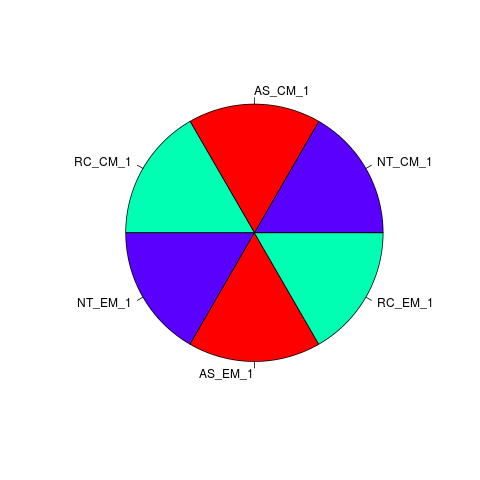

In [8]:
%%R -i color_num,samples,color_group -o colors 
# calculate colors for UCSC genome browser tracks
library(grDevices)
# start from 0.25 to skip yellow colors
colors = rainbow(color_num, start = 0.45, end = 1) 
print('Using default color grouping for UCSC genome browser.\n')
pie(rep(1,length(samples)), labels = samples, col=colors[unlist(color_group)])  
colors = apply(col2rgb(colors), 2, function(x) paste0(x, collapse=","))  

## Find, download, merge, and rename fastq files
Fastq files with the sam prefix will be merged and renamed using the corresponding "sample" name defined in sample_description.csv.

In [57]:
# count raw reads
fastq_files = sorted(glob.glob(os.path.join(rawfastq_dir, '*.fastq')))
with mp.Pool(processes=THREADS) as pool: 
    raw_fastq_counts = pool.map(count_fastq, fastq_files)
    
raw_fastq_counts = pd.Series([x[1] for x in raw_fastq_counts], 
                             [x[0] for x in raw_fastq_counts], 
                             name = "Raw")

## FASTQ QC using R
1. python list -> R list (not vector)
2. Multiple inputs after -i can be separated using ",", without space.

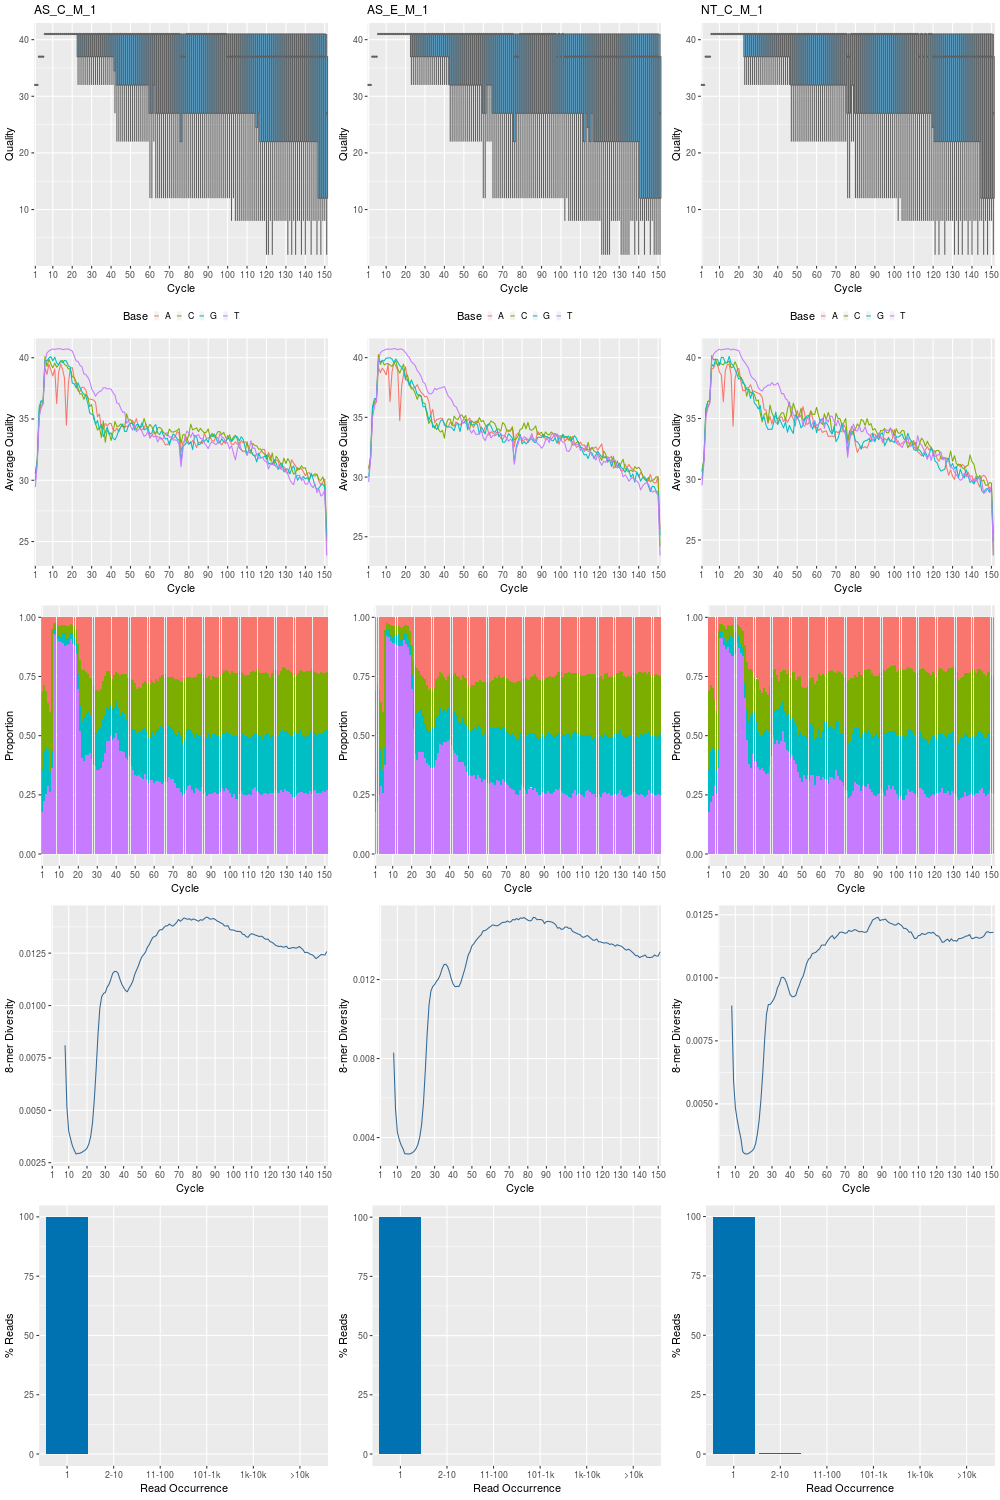

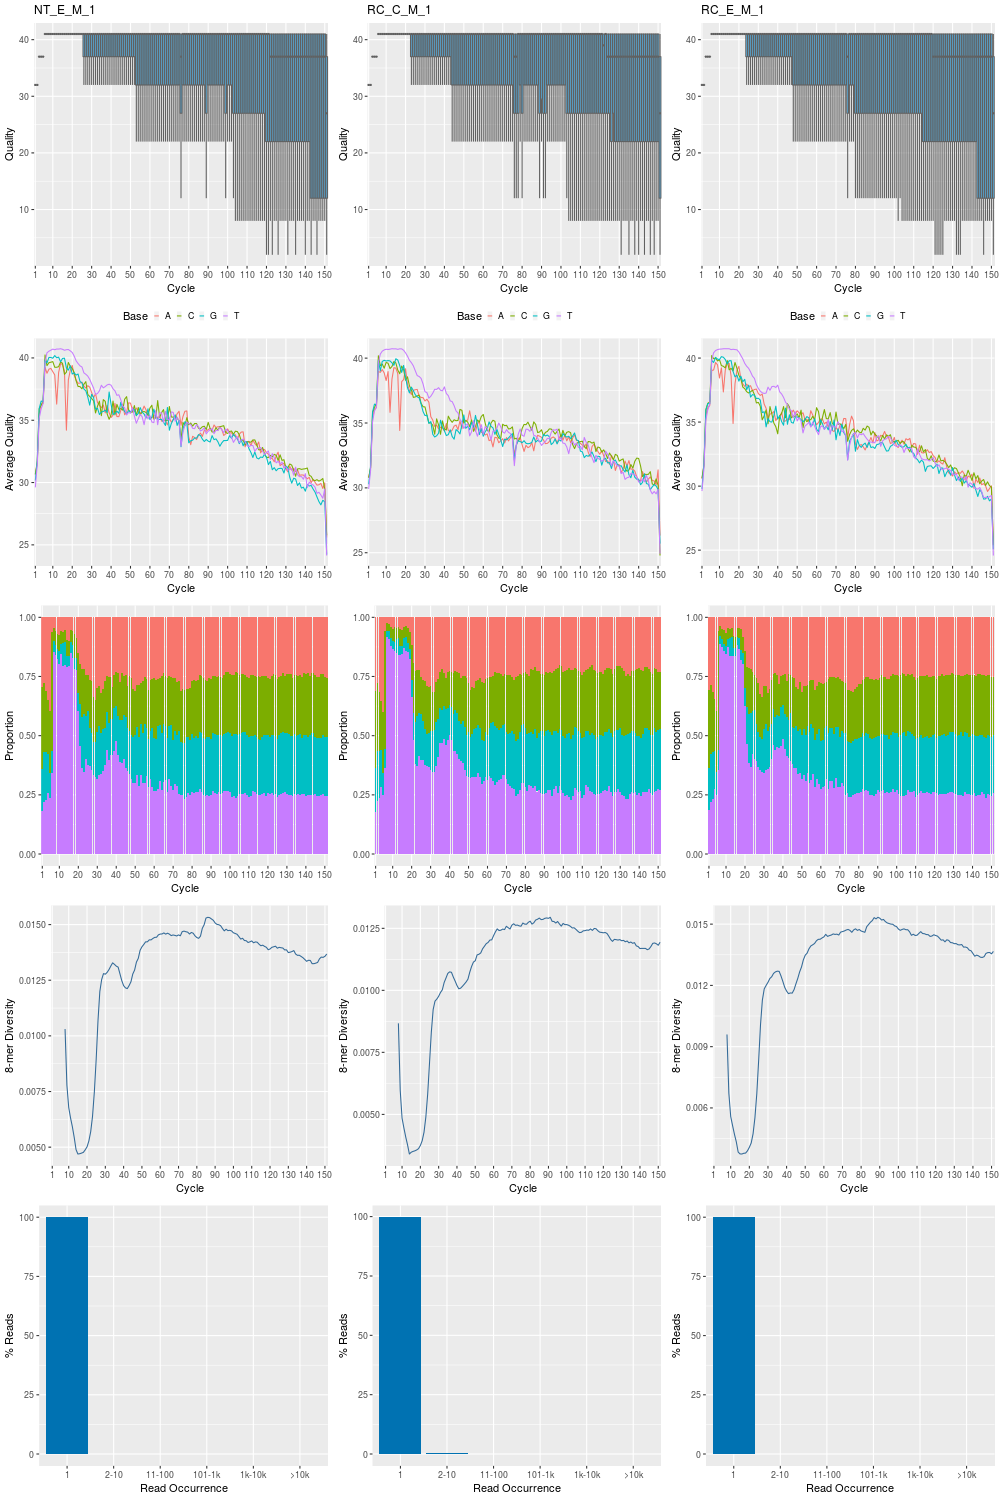

In [60]:
%%R -i fastq_files,FASTQ_QC_PLOT_NUM_COLUMNS,result_dir -w 1000 -h 1500

## load helper functions
source("module/FastqQC.R")
library(foreach)
library(doParallel)

## Step 1: Creat list of plots using parellel computing             
registerDoParallel()   
getDoParWorkers()   
# parallel computing
fqlist = foreach(f=1:length(fastq_files), 
                 .packages=c("ShortRead", "Biostrings")) %dopar%{
    seeFastq(fastq=fastq_files[[f]])
    }
names(fqlist) <- sapply(fastq_files, function(x) sub(".+\\/(.+).fastq", "\\1", x))                     

## Step 2: Output pdf and browser image              
n = FASTQ_QC_PLOT_NUM_COLUMNS                
mycol = seq(along=fqlist)     
myrow <- c(1, 3, 2, 4)
 
if(length(mycol) %% n){
  groups = 0:floor(length(mycol)/n)
}else{
  groups = 0:(length(mycol)/n - 1)
}
                        
# make pdf plots                        
pdf(file.path(result_dir, "fastqReport.pdf"), height=20, width=4*n)                         
for(group in groups){
  if(group < max(groups)){
    subcol = mycol[n*group + 1:n]
  }else{
    subcol = mycol[(n*group + 1):length(mycol)]
  }
  seeFastqPlot(fqlist[subcol], arrange=myrow, n = n)
}
dev.off()  
                        
# print to screen
for(group in groups){
  if(group < max(groups)){
    subcol = mycol[n*group + 1:n]
  }else{
    subcol = mycol[(n*group + 1):length(mycol)]
  }
  seeFastqPlot(fqlist[subcol], arrange=myrow, n = n)
} 

**Automatically figure out the number of random nucleotides in the 3' adapter (5' end of the reads when the libraries are sequenced in reverse direction)** Usually the base after the random nucleotides has the highest frequency of Ts.

In [62]:
%%R -o random_NT_lens
cycle_with_max_T_frequency = function(fq){
    base_frequency = fq$bstats
    T_frequency = subset(base_frequency, Base == "T")
    which.max(diff(T_frequency$Frequency))
}
# use all the samples to calculate random NT length
#random_NT_len = median(sapply(fqlist, cycle_with_max_T_frequency))
random_NT_lens = sapply(fqlist, cycle_with_max_T_frequency)
cat("Number of random nucleotides in 3' adapter:", random_NT_lens)

Number of random nucleotides in 3' adapter: 6 6 6 6 6 6

## Clip adapters 

In [63]:
if SEQUENCER == 'hiseq':
    # clip the read 5' end adapter (from 3' adapter) and only keep 80 (150-70) nt
    cmds = ['cutadapt -u -70 -a NNNNTGGAATTCTCGGGTGCCAAGG -n 1 -O 10 -m ' +
        str(CUTADAPT_MINLEN) + ' -f fastq -q 10 ' + fastq_file +
        ' -o ' + fastq_file.replace('.fastq', '.clipped.fastq').
        replace('rawfastq', 'fastq') + ' && rm ' + fastq_file for fastq_file in
        sorted(glob.glob(os.path.join(rawfastq_dir, '*.fastq')))]
    
elif SEQUENCER == 'nextseq':
    # clip the read 5' end adapter (from 3' adapter)
    cmds = ['cutadapt -a NNNNTGGAATTCTCGGGTGCCAAGG -n 1 -O 10 -m ' +
        str(CUTADAPT_MINLEN) + ' -f fastq -q 10 ' + fastq_file +
        ' -o ' + fastq_file.replace('.fastq', '.clipped.fastq').
        replace('rawfastq', 'fastq') + ' && rm ' + fastq_file for fastq_file in
        sorted(glob.glob(os.path.join(rawfastq_dir, '*.fastq')))]



with mp.Pool(processes=THREADS) as pool: 
    pool.map(os.system, cmds)

In [64]:
# count clipped reads
clipped_fastq_files = sorted(glob.glob(os.path.join(fastq_dir, 
                                                    '*clipped.fastq')))
with mp.Pool(processes=THREADS) as pool: 
    clipped_fastq_counts = pool.map(count_fastq, clipped_fastq_files)
clipped_fastq_counts = pd.Series([x[1] for x in clipped_fastq_counts], 
                                 [x[0] for x in clipped_fastq_counts], 
                                 name = "Clipped")

if SAVE_SPACE:
    cmd = 'rm -r ' + rawfastq_dir
    os.system(cmd)

## Trim 5' Ts 

In [65]:
clipped_fastq_files = sorted(glob.glob(os.path.join(fastq_dir, '*clipped.fastq')))

with mp.Pool(processes=THREADS) as pool:
    pool.starmap(fastq_trim_Ts_2, list(zip(clipped_fastq_files, list(random_NT_lens))))

trimmed_fastq_files = sorted(glob.glob(os.path.join(fastq_dir, 
                                                    '*clipped.trimmed.fastq')))
# count trimmed reads
with mp.Pool(processes=THREADS) as pool: 
    trimmed_fastq_counts = pool.map(count_fastq, trimmed_fastq_files)
    
trimmed_fastq_counts = pd.Series([x[1] for x in trimmed_fastq_counts], 
                                 [x[0] for x in trimmed_fastq_counts], 
                                 name = "Trimmed")    
    
if SAVE_SPACE:
    cmd = 'rm ' + ' '.join(clipped_fastq_files)
    os.system(cmd)    

## Map the reads to the genome using STAR 

AlignEndsType is set to EndToEnd.
According to the STAR manual, add the following lines to /etc/sysctl.conf:
1. kernel.shmmax = 31000000000 
2. kernel.shmall = 7568360

Then run 'sudo /sbin/sysctl -p' to allow large shared memory blocks.

In [66]:
# commands for mapping reads
cmds = ['STAR --runThreadN ' + str(THREADS) + ' --genomeDir ' + genome_index +
        ' --genomeLoad LoadAndKeep --readFilesIn ' + fastq_file +
        ' --alignEndsType EndToEnd --outFilterType BySJout --outFilterMultimapNmax 10 \
        --alignSJoverhangMin 8 --alignSJDBoverhangMin 1 --alignIntronMin 20 \
        --alignIntronMax 1000000 --outFileNamePrefix ' +
        fastq_file.replace('/fastq/', '/sam/').replace('fastq', '') for fastq_file in
        sorted(glob.glob(os.path.join(fastq_dir, '*trimmed.fastq')))]

# commands for removing fastq files
cmds_rm = ['rm ' + fastq_file for fastq_file in 
           sorted(glob.glob(os.path.join(fastq_dir, '*trimmed.fastq')))]  

# map reads then delete fastq files immediately
for i in range(len(cmds)):
    os.system(cmds[i])    
    if SAVE_SPACE:
        os.system(cmds_rm[i])
    
# remove genome from memory. Note "--genomeDir" is still needed!
cmd = 'STAR --genomeDir ' + genome_index + ' --genomeLoad Remove'
os.system(cmd)

#trimmed_fastq_files = glob.glob(os.path.join(fastq_dir, '*trimmed.fastq'))
#if SAVE_SPACE:
#    cmd = 'rm ' + ' '.join(trimmed_fastq_files)
#    os.system(cmd) 

0

## Identfy PASS reads

1. Unlike pool.map(), pool.starmap() allows passing multiple arguments to functions.
2. If I pass genome to each process, I will get an error.

In [67]:
# genome loaded into memory is available for all processes
genome = load_fasta_genome(genome_dir)

# list of sam files as input
input_files = sorted(glob.glob(os.path.join(sam_dir, '*Aligned.out.sam')))

# try parallel computing, which requires more disk space
try:
    with mp.Pool(processes=THREADS) as pool:
        pool.starmap(pick_PASS_4, [(input_file, 10, 'reverse')
                               for input_file in input_files])
except OSError:
    os.system('rm ' + sam_dir + '/*pass')
    print("No space left on device. Trying again with parallel computing turned off.")
    for input_file in input_files:
        print("Processing ", input_file)
        pick_PASS(sam_file = input_file)
    
del genome  # release memory

#if SAVE_SPACE:
#    cmd = 'rm ' + ' '.join(input_files)
#    os.system(cmd)

## Count unique PASS reads

In [68]:
input_files = sorted(glob.glob(os.path.join(sam_dir, '*Aligned.out.pass')))
# parallel computing
with mp.Pool(processes=THREADS) as pool:
    pool.starmap(select_unique_fragments, list(zip(input_files, list(random_NT_lens))))

## Cluster PASS reads

In [69]:
# this steps cannot be parallized. I have tried to run the following steps in parallel,
# but some how the second job did not finish and did not complain.

# cluster all PASS reads
cluster_reads_in_sam_dir(file_pattern='.Aligned.out.pass',
                             outfile='cluster.all.reads.csv',
                             direction='reverse',
                             max_distance=MAX_PA_DISTANCE)
# cluster unique PASS reads
cluster_reads_in_sam_dir(file_pattern='.Aligned.out.unique.pass',
                             outfile='cluster.unique.reads.csv',
                             direction='reverse',
                             max_distance=MAX_PA_DISTANCE)    

Clustering reads...
Writing to file...
Clustering reads...
Writing to file...


## Read number statistics

In [70]:
### file names for PASS files
pass_files = sorted(glob.glob(os.path.join(sam_dir, 
                                           '*clipped.trimmed.Aligned.out.pass')))
nonpass_files = sorted(glob.glob(os.path.join(sam_dir, 
                                              '*clipped.trimmed.Aligned.out.nopass')))
upass_files = sorted(glob.glob(os.path.join(sam_dir, 
                                            '*clipped.trimmed.Aligned.out.unique.pass')))
ref_files = sorted(glob.glob(os.path.join(sam_dir, 
                                          '*clipped.trimmed.Aligned.out.ref')))

### parallel computing
with mp.Pool(processes=THREADS) as pool: 
    pass_counts = pool.map(count_pass, pass_files)
pass_counts = pd.Series([x[1] for x in pass_counts], 
                        [x[0] for x in pass_counts], 
                        name = "PASS")

with mp.Pool(processes=THREADS) as pool: 
    nonpass_counts = pool.map(count_pass, nonpass_files)
nonpass_counts = pd.Series([x[1] for x in nonpass_counts], 
                           [x[0] for x in nonpass_counts], 
                           name = "nonPASS")

with mp.Pool(processes=THREADS) as pool: 
    upass_counts = pool.map(count_pass, upass_files)
upass_counts = pd.Series([x[1] for x in upass_counts], 
                         [x[0] for x in upass_counts], 
                         name = "uPASS")

with mp.Pool(processes=THREADS) as pool: 
    ref_counts = pool.map(count_pass, ref_files)
ref_counts = pd.Series([x[1] for x in ref_counts], 
                       [x[0] for x in ref_counts], 
                       name = "Ref")

### Save and display the table
count_stats = pd.concat([raw_fastq_counts, clipped_fastq_counts, 
                         trimmed_fastq_counts, pass_counts, 
                         nonpass_counts, upass_counts, ref_counts], axis = 1)
count_stats['Clipped%'] = round(count_stats.Clipped/count_stats.Raw * 100, 1)
count_stats['Trimmed%'] = round(count_stats.Trimmed/count_stats.Clipped * 100, 1)
count_stats['MAP%'] = round((count_stats.PASS + 
                             count_stats.nonPASS)/count_stats.Trimmed * 100, 1)
count_stats['PASS%'] = round(count_stats.PASS/(count_stats.PASS + 
                                               count_stats.nonPASS) * 100, 1)
count_stats['uPASS%'] = round(count_stats.uPASS/count_stats.PASS * 100, 1)
count_stats.index.name = 'Sample'
count_stats.to_csv(os.path.join(result_dir, 'ReadStats.csv'))

count_stats

,Raw,Clipped,Trimmed,PASS,nonPASS,uPASS,Ref,Clipped%,Trimmed%,MAP%,PASS%,uPASS%
Sample,,,,,,,,,,,,
AS_C_M_1,20336015,20087819,19775958,7935940,2281311,4371141,0,98.8,98.4,51.7,77.7,55.1
AS_E_M_1,19831252,19511876,19141593,8313583,2291747,4995405,0,98.4,98.1,55.4,78.4,60.1
NT_C_M_1,17941284,17357593,17094958,5222647,2349419,2820067,0,96.7,98.5,44.3,69.0,54.0
NT_E_M_1,18677381,17647960,17241928,6878130,2891651,4451328,0,94.5,97.7,56.7,70.4,64.7
RC_C_M_1,15962498,15730852,15513212,4900692,2227557,2787946,0,98.5,98.6,45.9,68.8,56.9
RC_E_M_1,23194272,22213241,21793451,9293822,3191140,5483451,0,95.8,98.1,57.3,74.4,59.0


## T-stretch statistics

In [71]:
# summarize T-stretch length in different files
TS = count_5Ts_in_folder(sam_dir=sam_dir)

png 
  2 


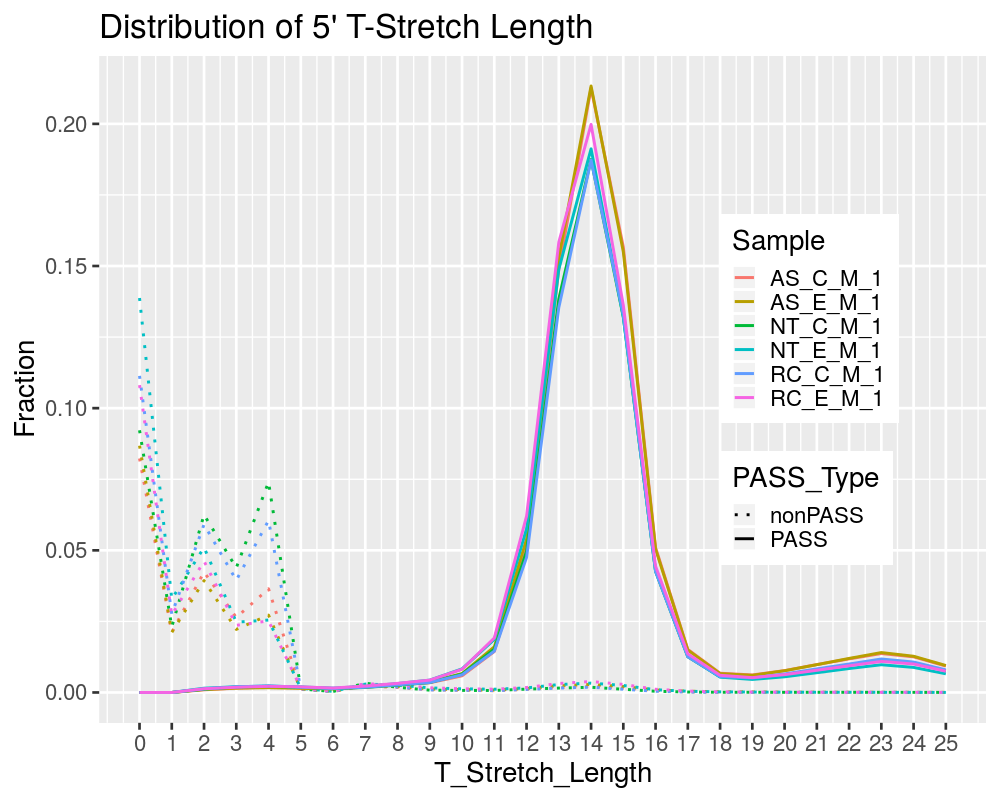

In [72]:
%%R -i result_dir,TS -w 1000 -h 800 -r 100

require(dplyr)
require(tidyr)
require(magrittr)
require(ggplot2)

# convert to "long" format
TS = gather(TS, sample_name, Count, -1)
# re-format values
TS$PASS_Type = toupper(sub("^.+\\.(.+)$", "\\1", TS$sample_name))
TS$PASS_Type = sub("NO", "non", TS$PASS_Type)
TS$Sample = sub("(^.+)\\.(.+)$", "\\1", TS$sample_name)
# calculate percentage
TS %<>% group_by(Sample) %>% mutate(Fraction = Count/sum(Count))  

# create the plot 
theme_set(theme_gray(base_size = 20))
p = ggplot(TS, aes(x = T_Stretch_Length, y = Fraction, color = Sample)) + 
    geom_line(aes(linetype = PASS_Type), size = 1) + 
    scale_linetype_manual(values = c(3,1)) +
    scale_x_continuous(limits = c(0, 25), breaks = 0:25) +
    theme(legend.position=c(0.8, 0.5))  + 
    ggtitle("Distribution of 5' T-Stretch Length")

# display in notebook
print(p)

# print to pdf
pdf(file.path(result_dir, 'T_stretch_len_all.pdf'), 10, 8)
print(p)
dev.off()

## Create UCSC genome browser tracks 

In [73]:
samtools = '~/software/ucsc/samtools '
genomeCoverageBed = '~/software/ucsc/genomeCoverageBed '
genome_size = '~/projects/fud/ucsc/genomes/' + GENO + '.chrom.sizes'
bedGraphToBigWig = '~/software/ucsc/bedGraphToBigWig '

In [74]:
# call the function to make UCSC genome browser tracks
make_url(project, EXPERIMENT, sam_dir, genome_size, genomeCoverageBed,
         bedGraphToBigWig)

In [75]:
# prepare for copying files
if not os.path.exists(os.path.join(sam_dir, PROJECT)):
    os.makedirs(os.path.join(sam_dir, PROJECT))
os.system('mkdir ' + os.path.join(sam_dir, PROJECT, EXPERIMENT))
os.system('mv ' + os.path.join(sam_dir, '*.bw ') +
          os.path.join(sam_dir, PROJECT, EXPERIMENT))
os.system('mv ' + os.path.join(sam_dir, 'bigwigCaller.txt ') +
          os.path.join(sam_dir, PROJECT, EXPERIMENT))

0

In [76]:
# copy the bigwig and track definition files to the http-enabled intron server
cmd = 'scp -r ' + os.path.join(sam_dir, PROJECT) + \
      ' zhengdh@intron.njms.rutgers.edu:' + \
      '~/../www/zhengdh/bigwig/'
os.system(cmd)
cmd = 'rm -r ' + os.path.join(sam_dir, PROJECT)
os.system(cmd)

if SAVE_SPACE:
    cmd = 'rm -r ' + sam_dir
    os.system(cmd)

url = 'https://genome.ucsc.edu/cgi-bin/hgTracks?db=' + GENO + \
      '&position=chr17%3A35092728-35095537&hgct_customText=' + \
      'http://intron.njms.rutgers.edu/zhengdh/bigwig/' + PROJECT + '/' + \
    EXPERIMENT + '/bigwigCaller.txt'
print('The following URL will be opened in a new tab automatically:\n')
print(url)
#msg = textwrap.fill(url, width=100)
#print(msg)
# wait for the server to be ready
sleep(5)
import webbrowser
_ = webbrowser.open(url)

The following URL will be opened in a new tab automatically:

https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&position=chr17%3A35092728-35095537&hgct_customText=http://intron.njms.rutgers.edu/zhengdh/bigwig/stress/181210/bigwigCaller.txt


## Download UCSC genome browser images for selected genes

In [34]:
import pandas as pd
input_dir = Path(result_dir)/"PM"
output_dir = input_dir/"UCSC_snapshot"
output_dir.mkdir(exist_ok=True, parents=True)
df = pd.read_csv(input_dir/"NT_normalized_deltaPM.csv")
print(df.shape)
df = df[df["NT_diff_1_norm_RED_n=10"].abs() >= 1].sort_values("gene_symbol")
print(df.shape)
df.columns
#df.head()

(1277, 22)
(429, 22)


Index(['gene_symbol', 'proximal_pA', 'distal_pA', 'UTR_length_proximal',
       'UTR_length_distal', 'aUTR_length', 'NT_CP_CM_1_RED', 'NT_EP_EM_1_RED',
       'NT_P_M_1_RED', 'NT_P_M_3_RED', 'NT_P_M_4_RED',
       'NT_CP_CM_1_norm_RED_n=5', 'NT_EP_EM_1_norm_RED_n=5',
       'NT_diff_1_norm_RED_n=5', 'NT_CP_CM_1_norm_RED_n=10',
       'NT_EP_EM_1_norm_RED_n=10', 'NT_diff_1_norm_RED_n=10',
       'NT_CP_CM_1_norm_RED_n=20', 'NT_EP_EM_1_norm_RED_n=20',
       'NT_diff_1_norm_RED_n=20', 'description', 'url'],
      dtype='object')

In [35]:
from urllib.request import urlopen, urlretrieve
for gene_symbol, url in zip(df.gene_symbol, df.url):
    print(gene_symbol)
    print(url)
    
    with urlopen(url) as conn:
        source = conn.read(100000)
        image_location = re.search('\/trash\/hgt\/hgt_genome(.*?)\.png',
                               str(source)).group()
        url_to_image = 'https://genome.ucsc.edu' + image_location
        UCSC_snapshot = output_dir/(gene_symbol+".png")
        urlretrieve(url_to_image, UCSC_snapshot)
    



1700017B05Rik
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr9%3A57100705-57101585&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
1810009A15Rik
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr19%3A8964326-8968021&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
1810043G02Rik
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr10%3A77447235-77448499&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
2210013O21Rik
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chrX%3A150175791-150175854&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
2310022B05Rik
https://genome.ucsc.edu/cgi-

Asap1
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr15%3A63917577-63920945&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Ascc2
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr11%3A4582228-4586859&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Atad1
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr19%3A32746924-32747443&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Atmin
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr8%3A119481044-119485444&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Atp5f1
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=d

Cherp
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr8%3A74984302-74984626&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Chic2
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr5%3A75402405-75402580&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Chmp3
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr6%3A71529463-71532270&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Chtop
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr3%3A90302512-90303985&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Clns1a
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=defa

Dusp3
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr11%3A101831299-101835943&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Dusp7
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr9%3A106276367-106278614&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Dync1li2
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr8%3A106940955-106943463&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Dynll2
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr11%3A87792181-87795598&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Eef1g
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtMo

Gng12
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr6%3A66966260-66972965&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Golt1b
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr6%3A142349792-142353239&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Gorasp2
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr2%3A70529344-70529928&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Gpi1
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr7%3A34987135-34987192&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Grk2
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=de

Letmd1
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr15%3A100308070-100310102&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Lgals1
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr15%3A78760488-78761032&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Lias
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr5%3A65800097-65800522&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Lin37
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr7%3A31340445-31340524&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Loxl1
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=

Msl3
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chrX%3A165087777-165093472&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Mtch2
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr2%3A90704923-90707423&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Mthfd2
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr6%3A83255676-83255773&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Mtmr10
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr7%3A71485096-71485359&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Mul1
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=def

Parva
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr7%3A119731141-119736548&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Pcbp2
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr15%3A102328787-102331067&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Pdhx
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr2%3A102861923-102862031&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Pear1
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr3%3A87552640-87554192&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Phf20l1
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeTy

Rbbp4
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr4%3A128986688-128986977&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Rbm34
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr8%3A129470164-129473845&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Rbm39
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr2%3A155972637-155974025&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Rbms1
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr2%3A60587244-60591272&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Rbpj
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=

Saraf
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr8%3A35233860-35233912&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Sav1
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr12%3A71065490-71067538&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Sdc2
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr15%3A32961308-32965541&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Selenok
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr14%3A30787904-30788065&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Senp1
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=de

St13
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr15%3A81193411-81196163&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Stard5
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr7%3A90788996-90791444&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Stk11
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr10%3A79593110-79593526&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Suds3
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr5%3A117541313-117542824&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Supv3l1
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType

Txn2
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr15%3A77745397-77745721&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Uap1
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr1%3A172072115-172072191&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Ube2b
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr11%3A51799700-51799949&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Ube2c
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr2%3A164598349-164598406&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Ube2d2a
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType

In [37]:
import pandas as pd
input_dir = Path(result_dir)/"PM"
output_dir = input_dir/"AS_UCSC_snapshot"
output_dir.mkdir(exist_ok=True, parents=True)
df = pd.read_csv(input_dir/"AS_normalized_deltaPM.csv")
print(df.shape)
df = df[(df["AS_diff_1_norm_RED_n=10"].abs() >= 1) & (df['aUTR_length'] >= 1000)].sort_values("gene_symbol")
print(df.shape)
df.columns
#df.head()

(1560, 35)
(93, 35)


Index(['gene_symbol', 'proximal_pA', 'distal_pA', 'ER', 'Golgi', 'Membrane',
       'Nucleus', 'Cytoplasm', 'Mitochondria', 'Lysosome', 'Peroxisome',
       'Cytoskeleton', 'Secreted', 'Secreted_likely', 'Secreted_highlylikely',
       'Secreted_weaklylikely', 'UTR_length_proximal', 'UTR_length_distal',
       'aUTR_length', 'AS_CP_CM_1_RED', 'AS_EP_EM_1_RED', 'AS_P_M_1_RED',
       'AS_P_M_3_RED', 'AS_P_M_4_RED', 'AS_CP_CM_1_norm_RED_n=5',
       'AS_EP_EM_1_norm_RED_n=5', 'AS_diff_1_norm_RED_n=5',
       'AS_CP_CM_1_norm_RED_n=10', 'AS_EP_EM_1_norm_RED_n=10',
       'AS_diff_1_norm_RED_n=10', 'AS_CP_CM_1_norm_RED_n=20',
       'AS_EP_EM_1_norm_RED_n=20', 'AS_diff_1_norm_RED_n=20', 'description',
       'url'],
      dtype='object')

In [38]:
from urllib.request import urlopen, urlretrieve
for gene_symbol, url in zip(df.gene_symbol, df.url):
    print(gene_symbol)
    print(url)
    
    with urlopen(url) as conn:
        source = conn.read(100000)
        image_location = re.search('\/trash\/hgt\/hgt_genome(.*?)\.png',
                               str(source)).group()
        url_to_image = 'https://genome.ucsc.edu' + image_location
        UCSC_snapshot = output_dir/(gene_symbol+".png")
        urlretrieve(url_to_image, UCSC_snapshot)

1810013L24Rik
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr16%3A8856043-8859043&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Abhd5
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr9%3A122288091-122291491&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Adamtsl5
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr10%3A79801992-79804247&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Amz2
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr11%3A109297377-109300154&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Ankrd40
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastV

Gnb1
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr4%3A154931422-154934029&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Gng12
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr6%3A66966260-66972965&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Golt1b
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr6%3A142349792-142353239&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Grk2
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr19%3A4285484-4287557&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Hdgfrp3
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=d

Sh3pxd2a
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr19%3A47332130-47342273&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Slain2
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr5%3A73366550-73371239&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Slc30a1
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr1%3A193732440-193738608&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Slc35f6
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr5%3A30960455-30962582&hgsid=703198623_15Ka4gFZgGap6XtCm0vnqEZaW8iI
Smim7
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&lastVirtMod